<a href="https://colab.research.google.com/github/udlbook/udlbook/blob/main/Notebooks/Chap08/8_1_MNIST_1D_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 8.1: MNIST_1D_Performance**

This notebook runs a simple neural network on the MNIST1D dataset as in figure 8.2a. It uses code from https://github.com/greydanus/mnist1d to generate the data.

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.

In [1]:
# Run this if you're in a Colab to make a local copy of the MNIST 1D repository
#!git clone https://github.com/greydanus/mnist1d

Cloning into 'mnist1d'...
remote: Enumerating objects: 504, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 504 (delta 77), reused 92 (delta 60), pack-reused 381
Receiving objects: 100% (504/504), 14.74 MiB | 8.58 MiB/s, done.
Resolving deltas: 100% (230/230), done.


In [1]:
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import mnist1d

Let's generate a training and test dataset using the MNIST1D code.  The dataset gets saved as a .pkl file so it doesn't have to be regenerated each time.

In [2]:
!mkdir ./sample_data

args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='mnist1d_data.pkl', download=False, regenerate=False)

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

mkdir: ./sample_data: File exists
Did or could not load data from mnist1d_data.pkl. Rebuilding dataset...
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40


In [7]:
D_i = 40    # Input dimensions
D_k = 100   # Hidden dimensions
D_o = 10    # Output dimensions
# TO DO:
# Define a model with two hidden layers of size 100
# And ReLU activations between them
# Replace this line (see Figure 7.8 of book for help):
model = torch.nn.Sequential(
    torch.nn.Linear(D_i, D_k),
    nn.ReLU(),
    torch.nn.Linear(D_k, D_k),
    nn.ReLU(),
    torch.nn.Linear(D_k, D_o)
);


def weights_init(layer_in):
    # TO DO:
    # Initialize the parameters with He initialization
    # Replace this line (see figure 7.8 of book for help)
    if isinstance(layer_in, nn.Linear):
        nn.init.kaiming_normal_(layer_in.weight)
        layer_in.bias.data.fill_(0.0)


# Call the function you just defined
model.apply(weights_init)


Sequential(
  (0): Linear(in_features=40, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=10, bias=True)
)

In [17]:
def train_model(model, n_epoch=50, lr=0.05, momentum=0.9, step_size=10, gamma=0.5):
    # choose cross entropy loss function (equation 5.24)
    loss_function = torch.nn.CrossEntropyLoss()

    # construct SGD optimizer and initialize learning rate and momentum
    optimizer = torch.optim.SGD(model.parameters(), lr, momentum)

    # object that decreases learning rate by half every 10 epochs
    # when using step_size=10, gamma=0.5
    scheduler = StepLR(optimizer, step_size, gamma)
    x_train = torch.tensor(data['x'].astype('float32'))
    y_train = torch.tensor(data['y'].transpose().astype('long'))
    x_test= torch.tensor(data['x_test'].astype('float32'))
    y_test = torch.tensor(data['y_test'].astype('long'))
    
    # load the data into a class that creates the batches
    data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))
    
    # Initialize model weights
    model.apply(weights_init)

    # store the loss and the % correct at each epoch
    losses_train = np.zeros((n_epoch))
    errors_train = np.zeros((n_epoch))
    losses_test = np.zeros((n_epoch))
    errors_test = np.zeros((n_epoch))
    
    # loop over the dataset n_epoch times
    for epoch in range(n_epoch):
        # loop over batches
        for i, batch in enumerate(data_loader):
            # retrieve inputs and labels for this batch
            x_batch, y_batch = batch
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward pass -- calculate model output
            pred = model(x_batch)
            # compute the loss
            loss = loss_function(pred, y_batch)
            # backward pass
            loss.backward()
            # SGD update
            optimizer.step()
    
        # Run whole dataset to get statistics -- normally wouldn't do this
        pred_train = model(x_train)
        pred_test = model(x_test)
        _, predicted_train_class = torch.max(pred_train.data, 1)
        _, predicted_test_class = torch.max(pred_test.data, 1)
        errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
        errors_test[epoch]= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
        losses_train[epoch] = loss_function(pred_train, y_train).item()
        losses_test[epoch]= loss_function(pred_test, y_test).item()
        print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  test loss {losses_test[epoch]:.6f}, test error {errors_test[epoch]:3.2f}')
        
        # tell scheduler to consider updating learning rate
        scheduler.step()

    return errors_train, errors_test, losses_train, losses_test


def plot_results(errors_train, errors_test, losses_train, losses_test):
    # Plot the results
    fig, ax = plt.subplots()
    ax.plot(errors_train,'r-',label='train')
    ax.plot(errors_test,'b-',label='test')
    ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
    ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
    ax.set_title('TrainError %3.2f, Test Error %3.2f'%(errors_train[-1],errors_test[-1]))
    ax.legend()
    plt.show()
    
    # Plot the results
    fig, ax = plt.subplots()
    ax.plot(losses_train,'r-',label='train')
    ax.plot(losses_test,'b-',label='test')
    ax.set_xlim(0,n_epoch)
    ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
    ax.set_title('Train loss %3.2f, Test loss %3.2f'%(losses_train[-1],losses_test[-1]))
    ax.legend()
    plt.show()

Epoch     0, train loss 1.571808, train error 60.67,  test loss 1.652674, test error 68.10
Epoch     1, train loss 1.320150, train error 48.67,  test loss 1.465508, test error 59.10
Epoch     2, train loss 1.129313, train error 40.65,  test loss 1.346585, test error 52.70
Epoch     3, train loss 1.019345, train error 37.30,  test loss 1.273635, test error 49.60
Epoch     4, train loss 0.887707, train error 32.68,  test loss 1.174970, test error 46.00
Epoch     5, train loss 0.813242, train error 28.95,  test loss 1.141652, test error 43.10
Epoch     6, train loss 0.745331, train error 26.72,  test loss 1.136860, test error 44.40
Epoch     7, train loss 0.634294, train error 21.38,  test loss 1.070316, test error 40.50
Epoch     8, train loss 0.567624, train error 19.05,  test loss 1.065753, test error 40.20
Epoch     9, train loss 0.552625, train error 19.78,  test loss 1.107817, test error 41.80
Epoch    10, train loss 0.449427, train error 13.88,  test loss 1.030570, test error 38.30

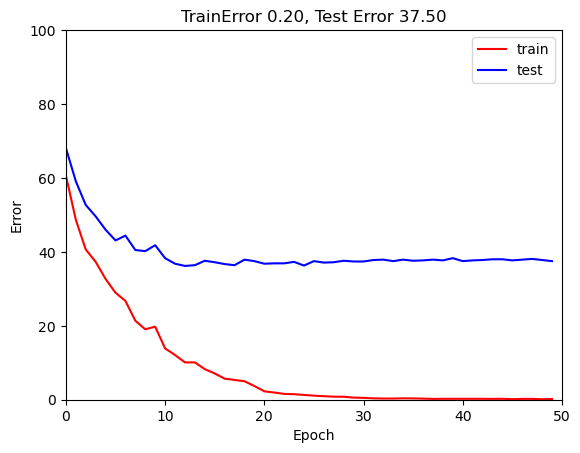

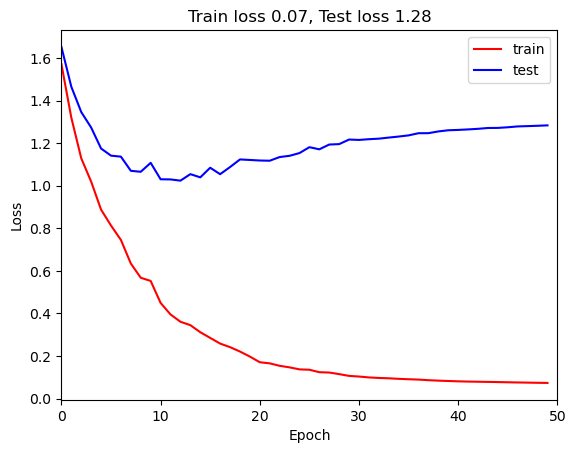

In [16]:
errors_train, errors_test, losses_train, losses_test = train_model(model)
plot_results(errors_train, errors_test, losses_train, losses_test)

**TO DO**

Play with the model -- try changing the number of layers, hidden units, learning rate, batch size, momentum or anything else you like.  See if you can improve the test results.

Is it a good idea to optimize the hyperparameters in this way?  Will the final result be a good estimate of the true test performance?

Epoch     0, train loss 1.490127, train error 56.55,  test loss 1.586910, test error 63.80
Epoch     1, train loss 1.164550, train error 42.42,  test loss 1.389753, test error 54.90
Epoch     2, train loss 0.910282, train error 30.57,  test loss 1.277599, test error 49.80
Epoch     3, train loss 0.766632, train error 28.18,  test loss 1.222722, test error 46.60
Epoch     4, train loss 0.537054, train error 18.45,  test loss 1.153957, test error 41.80
Epoch     5, train loss 0.358081, train error 12.05,  test loss 1.114738, test error 40.50
Epoch     6, train loss 0.446611, train error 17.20,  test loss 1.295152, test error 39.60
Epoch     7, train loss 0.217827, train error 7.55,  test loss 1.077563, test error 34.70
Epoch     8, train loss 0.184655, train error 6.72,  test loss 1.208895, test error 35.80
Epoch     9, train loss 0.103069, train error 2.82,  test loss 1.245098, test error 34.90
Epoch    10, train loss 0.021147, train error 0.07,  test loss 1.160919, test error 32.10
Epo

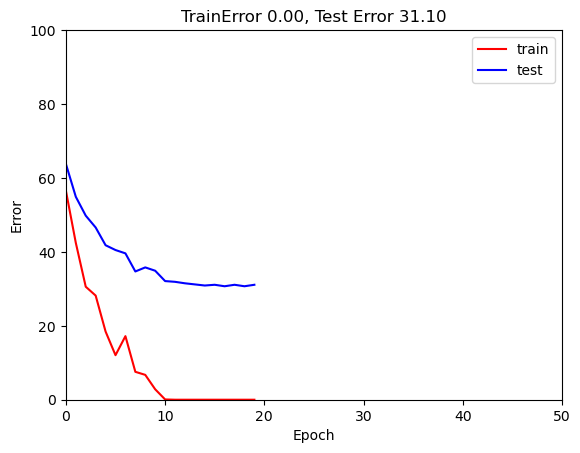

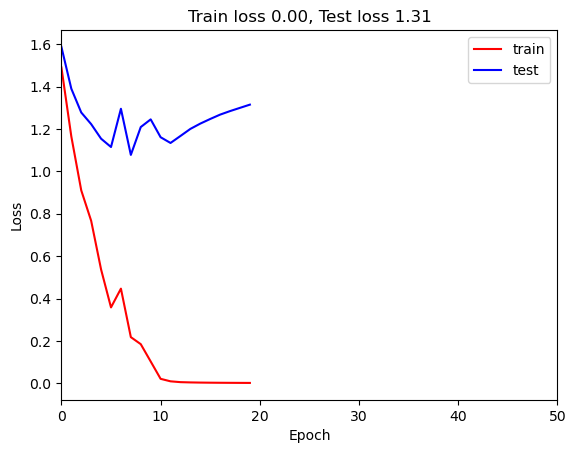

In [33]:
D_k = 300   # Hidden dimensions

model2 = torch.nn.Sequential(
    torch.nn.Linear(D_i, D_k),
    nn.ReLU(),
    torch.nn.Linear(D_k, D_k),
    nn.ReLU(),
    torch.nn.Linear(D_k, D_k),
    nn.ReLU(),
    torch.nn.Linear(D_k, D_k),
    nn.ReLU(),
    torch.nn.Linear(D_k, D_o)
);

model2.apply(weights_init)

errors_train, errors_test, losses_train, losses_test = \
    train_model(model2, n_epoch=20, lr=0.05, momentum=0.9, step_size=10, gamma=0.5)

plot_results(errors_train, errors_test, losses_train, losses_test)